In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from skimage import exposure

In [2]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [3]:
scene_df1 = pd.read_hdf('scene.hdf5')
scene_df2 = pd.read_hdf('scene2.hdf5')
scene_df3 = pd.read_hdf('scene3.hdf5')
car_scene_df1 = pd.read_hdf('car_scene.hdf5')
car_scene_df2 = pd.read_hdf('car_scene2.hdf5')
car_scene_df3 = pd.read_hdf('car_scene3.hdf5')

In [4]:
car_calibration_df1 = pd.read_hdf("car_calibration_set_1.hdf5")
car_calibration_df2 = pd.read_hdf("car_calibration_set_2.hdf5")

calibration_df1 = pd.read_hdf("calibration_set_1.hdf5")
calibration_df2 = pd.read_hdf("calibration_set_2.hdf5")

In [5]:
def median_denoised_df(scene_df):

    baseline = np.median(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)-baseline
    

In [6]:
def mean_denoised_df(scene_df):

    baseline = np.mean(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)-baseline

In [7]:
def median_denoised_video(scene):

    baseline = np.median(scene, axis =0)

    return scene-baseline

In [8]:


def median_intersection(arr, n):
    slices = np.array_split(arr, n, axis=0)
    
    # Calculate the median over axis 0 for each slice
    medians = np.array([np.median(s, axis=0) for s in slices])
    mean = np.mean(medians, axis = 0)    
    return arr- mean



In [25]:
all_scenes = [scene_df1,scene_df2,scene_df3,car_scene_df1,car_scene_df2, car_scene_df3]

for i, scene in enumerate(all_scenes):
    denoised = extract_static_noise_torch_df(scene)
    name = f"static_denoise_{i+1}.avi"
    save_video_from_images(denoised, name)

C:\Users\WillQuantique\AppData\Local\Temp\ipykernel_18916\3459172621.py:19: RuntimeWarning: invalid value encountered in cast
  img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


In [10]:
def select_least_contrasted_images(images, x):
    
    num_images = images.shape[0]
    num_selected = int(num_images * x / 100.0)
    
    contrasts = []
    for i in range(num_images):
        contrast = exposure.is_low_contrast(images[i])
        contrasts.append((i, contrast))
    
    contrasts.sort(key=lambda item: item[1])
    selected_indices = [item[0] for item in contrasts[:num_selected]]
    
    return images[selected_indices]


In [11]:
import torch

def is_low_contrast_torch(image, fraction_threshold=0.05):
    min_val = image.float().min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_val = image.float().max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    contrast = (max_val - min_val) / (max_val + min_val)
    return contrast < fraction_threshold

def select_least_contrasted_blocks(images, x):
    num_images, height, width = images.shape
    block_size = 32
    num_blocks_vertical = height // block_size
    num_blocks_horizontal = width // block_size
    num_selected = int(num_images * x / 100.0)
    
    images_torch = torch.tensor(images, dtype=torch.float32)
    blocks = images_torch.unfold(1, block_size, block_size).unfold(2, block_size, block_size)
    
    min_vals = blocks.contiguous().view(num_images, num_blocks_vertical, num_blocks_horizontal, -1).min(dim=-1)[0]
    max_vals = blocks.contiguous().view(num_images, num_blocks_vertical, num_blocks_horizontal, -1).max(dim=-1)[0]
    contrasts = (max_vals - min_vals) / (max_vals + min_vals)
    
    sorted_indices = contrasts.argsort(dim=0)
    best_blocks_indices = sorted_indices[:num_selected]
    
    selected_blocks = torch.gather(blocks, 0, best_blocks_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, block_size, block_size))
    
    selected_images = selected_blocks.permute(0, 3, 1, 4, 2).contiguous().view(num_selected, height, width)
    
    return selected_images.numpy().astype(np.uint8)









In [35]:

def calculate_entropy_batch(blocks):
    hist = torch.histc(blocks.float(), bins=256, min=0, max=255)
    hist = hist.view(blocks.shape[0], -1)
    
    prob = hist / hist.sum(dim=1, keepdim=True)
    entropy = -torch.sum(prob * torch.log2(prob + 1e-10), dim=1)
    
    return entropy

def select_least_entropy_blocks(images, x):
    num_images, height, width = images.shape
    block_size = 32
    num_blocks_vertical = height // block_size
    num_blocks_horizontal = width // block_size
    num_selected = int(num_images * x / 100.0)
    
    images_torch = torch.tensor(images, dtype=torch.float32)
    blocks = images_torch.unfold(1, block_size, block_size).unfold(2, block_size, block_size)
    
    blocks_flat = blocks.contiguous().view(num_images, num_blocks_vertical * num_blocks_horizontal, block_size * block_size)
    
    entropy_values = calculate_entropy_batch(blocks_flat.view(-1, block_size * block_size))
    entropy_values = entropy_values.view(num_images, num_blocks_vertical, num_blocks_horizontal)
    
    sorted_indices = entropy_values.argsort(dim=0)
    best_blocks_indices = sorted_indices[:num_selected]
    
    selected_blocks = torch.gather(blocks, 0, best_blocks_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, block_size, block_size))
    
    selected_images = selected_blocks.permute(0, 3, 1, 4, 2).contiguous().view(num_selected, height, width)
    
    return selected_images.numpy().astype(np.uint8)







In [113]:
import torch
import numpy as np

def ssim_batch(img1, img2, C1=0.01**2, C2=0.03**2):
    mu1 = torch.mean(img1, dim=(-2, -1), keepdim=True)
    mu2 = torch.mean(img2, dim=(-2, -1), keepdim=True)
    sigma1 = torch.var(img1, dim=(-2, -1), keepdim=True)
    sigma2 = torch.var(img2, dim=(-2, -1), keepdim=True)
    sigma12 = torch.mean((img1 - mu1) * (img2 - mu2), dim=(-2, -1), keepdim=True)
    
    ssim_index = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1**2 + mu2**2 + C1) * (sigma1 + sigma2 + C2))
    return ssim_index.mean(dim=(-2, -1))

def select_most_varied_frames_by_ssim(images, x, batch_size=10):
    num_images, height, width = images.shape
    num_selected = int(num_images * x / 100.0)
    
    images_torch = torch.tensor(images, dtype=torch.float32)
    
    ssim_matrix = torch.zeros((num_images, num_images))
    
    for i in range(0, num_images, batch_size):
        end_i = min(i + batch_size, num_images)
        img1_batch = images_torch[i:end_i].unsqueeze(1)
        
        for j in range(0, num_images, batch_size):
            end_j = min(j + batch_size, num_images)
            img2_batch = images_torch[j:end_j].unsqueeze(0)
            
            ssim_batch_result = ssim_batch(img1_batch, img2_batch)
            ssim_matrix[i:end_i, j:end_j] = ssim_batch_result.squeeze()
    
    # Convert SSIM to difference measure (1 - SSIM)
    diff_matrix = 1 - ssim_matrix
    
    # Select the first frame randomly
    selected_indices = [0]
    
    for _ in range(1, num_selected):
        last_selected = selected_indices[-1]
        diff_with_last_selected = diff_matrix[last_selected]
        
        # Mask already selected indices
        diff_with_last_selected[selected_indices] = -1
        
        # Select the frame with the highest difference to the last selected frame
        next_index = torch.argmax(diff_with_last_selected).item()
        selected_indices.append(next_index)
    
    selected_frames = images[selected_indices]
    
    return selected_frames
# Example usage
# images = np.random.randint(0, 256, (100, 480, 640), dtype=np.uint8)
# result = select_most_varied_frames_by_ssim(images, 50)



In [12]:
lci = select_least_contrasted_images(arr, 70)


In [38]:
lcb = select_least_contrasted_blocks(arr,10)

In [120]:
ssim = select_most_varied_frames_by_ssim(arr, 15)

In [25]:
lcb.shape

(60, 480, 640)

In [129]:
save_video_from_images(denoised,"ssim_median_test.avi", 60)

In [157]:
def common_values(x, y, threshold=100):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x, 0)
    
    return common

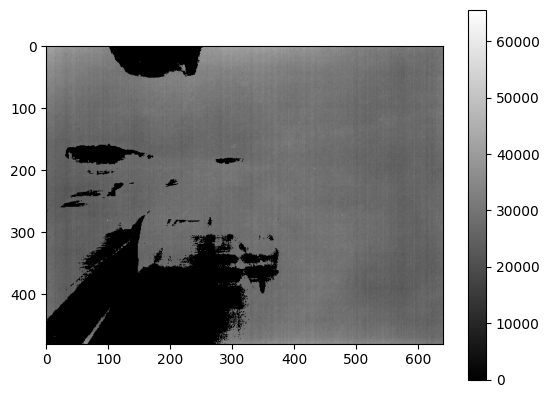

In [162]:
median = np.median(arr, axis =0)
mean = np.mean(arr, axis =0)
common = common_values(mean, median, 1000)
plt.imshow(common, cmap='gray')
plt.colorbar()

plt.show()

In [203]:
import numpy as np
from scipy.ndimage import label

def common_values_within_threshold(x, y, threshold=500):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x, 0)
    
    return common

def detect_black_chunks(image):
    # Ensure the image is a binary image (black and white)
    binary_image = (image == 0).astype(int)
    
    # Label connected components
    labeled_image, num_features = label(binary_image)
    
    # Extract indices of black pixel chunks
    chunks = []
    for i in range(1, num_features + 1):
        chunk_indices = np.argwhere(labeled_image == i)
        chunks.append(chunk_indices)
    
    return chunks

def normalize_image(image):
    # Normalize the image to the range [0, 1]
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def fill_black_pixels(arr, threshold=500, max_iterations=100):
    initial_indices = np.random.choice(arr.shape[0], size=10, replace=False)
    initial_subset = arr[initial_indices]
    
    # Update the common image with new mean and median from the subset
    initial_subset_median = np.median(initial_subset, axis=0)
    initial_subset_mean = np.mean(initial_subset, axis=0)
    initial_common = common_values_within_threshold(initial_subset_mean, initial_subset_median, threshold)
    
    black_chunks = detect_black_chunks(initial_common)
    
    filled_image = initial_common.copy()
    
    # Store the initial state
    filled_images_history = [filled_image.copy()]
    
    for iteration in range(max_iterations):
        if not black_chunks:
            break
        
        # Randomly select a subset of images
        subset_indices = np.random.choice(arr.shape[0], size=10, replace=False)
        subset = arr[subset_indices]
        
        # Update the common image with new mean and median from the subset
        subset_median = np.median(subset, axis=0)
        subset_mean = np.mean(subset, axis=0)
        subset_common = common_values_within_threshold(subset_mean, subset_median, threshold)
        
        # Normalize the subset_common image
        subset_common = normalize_image(subset_common)
        
        # Fill the black pixel chunks
        for chunk in black_chunks:
            for (x, y) in chunk:
                if filled_image[x, y] == 0 and subset_common[x, y] != 0:
                    filled_image[x, y] = subset_common[x, y]
        
        # Store the intermediate filled image
        filled_images_history.append(filled_image.copy())
        
        # Re-detect black chunks
        black_chunks = detect_black_chunks(filled_image)
    
    # Normalize the final filled image
    filled_image = normalize_image(filled_image)
    
    return filled_image, filled_images_history

# Example usage
# arr = np.random.randint(0, 256, (100, 480, 640), dtype=np.uint8)
# final_image, history = fill_black_pixels(arr)



In [224]:
video = np.stack(car_scene_df1["image"].values)

arr = video

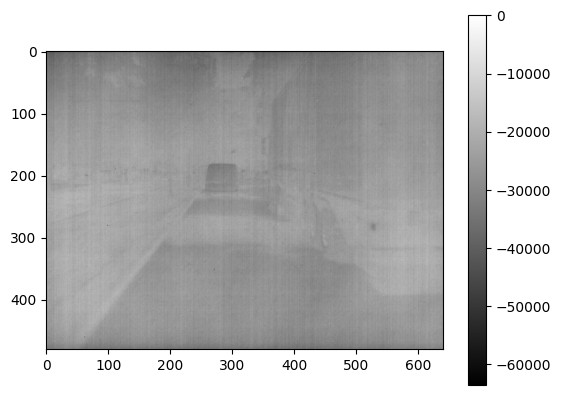

In [242]:

quantarr = np.quantile(arr, 0.75, axis = 0)
corrected = quantarr-arr
plt.imshow(corrected[100], cmap='gray')
plt.colorbar()

plt.show()

In [241]:
save_video_from_images(corrected, "quantile.avi")

In [204]:
thresh = 0.001
vid_name = "scene_1"
norm_arr = normalize_image(arr)
result, layers = fill_black_pixels(norm_arr, thresh)
save_video_from_images(norm_arr-result, f"iterative_MMpatching_{vid_name}_{thresh}.avi")



In [212]:
layrray = np.array(layers)

save_video_from_images(layrray, "layering.avi")



In [176]:
result2 = fill_black_pixels(arr, 500)


In [178]:
result3 = fill_black_pixels(arr, 200)

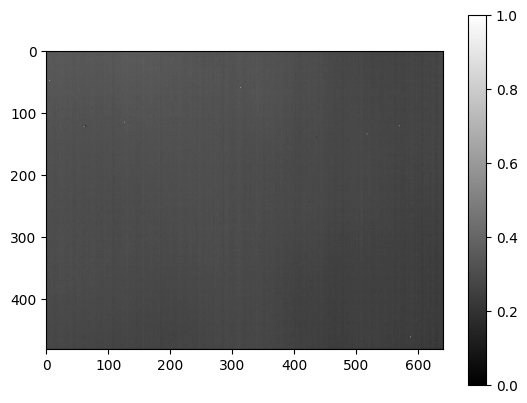

In [220]:
plt.imshow(result, cmap='gray')
plt.colorbar()

plt.show()

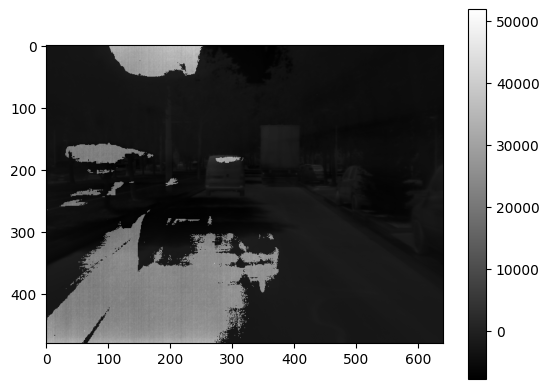

In [163]:
static = np.mean(arr, axis =0)
denoised = arr-common
plt.imshow(denoised[0], cmap='gray')
plt.colorbar()

plt.show()

In [ ]:
all_scenes = [scene_df1,scene_df2,scene_df3]

for i, scene in enumerate(all_scenes):
    name = f"MSE_car_scene_{i+1}.avi"
    noise = extract_noise_pattern(np.stack(scene["image"].values))
    cleaned = remove_noise_from_video(video, noise)
    save_video_from_images(cleaned, name)

